In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import scipy.ndimage
from scipy.io import wavfile
from scipy.signal import hilbert, resample

import pandas as pd

In [2]:
#read in WAV file
wav_path = 'noaa1.wav'
fs, audio = wavfile.read(wav_path)

In [3]:
## Resampling
coef = 20800 / fs

samples = int(coef * len(audio))
audio = resample(audio, samples)

In [4]:
hilbert_transformed = np.abs(hilbert(audio))

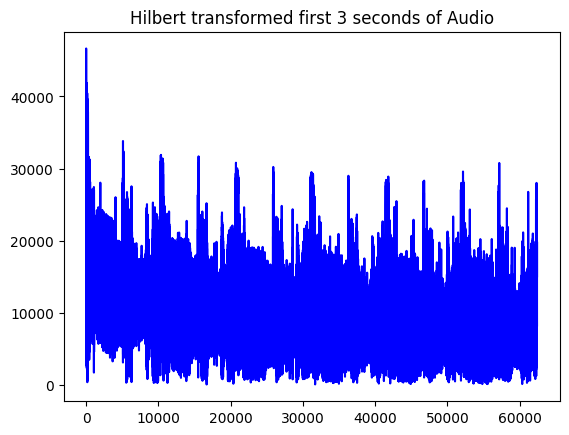

In [5]:
plt.plot(range(len(hilbert_transformed[:20800*3])), hilbert_transformed[:20800*3], color = 'blue')
plt.title('Hilbert transformed first 3 seconds of Audio')
plt.show()

In [6]:
resampled_demodulated = resample(hilbert_transformed, len(hilbert_transformed) // 5)
low, high = np.percentile(resampled_demodulated, (5, 95))

print(f'5th percentile (very black) is {low}, 95th percentile (very white) is {high}')

5th percentile (very black) is 3909.811395123542, 95th percentile (very white) is 15877.863030392657


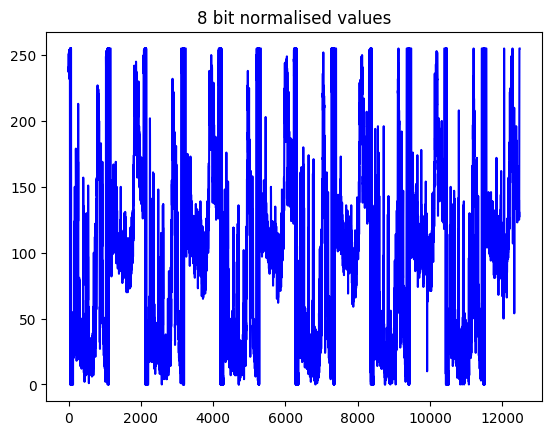

In [7]:
normalised_data = np.round((255 * (resampled_demodulated - low)) / (high - low)).clip(0, 255).astype(np.int16)

plt.plot(range(len(normalised_data[int(20800*297//5):int(20800*300//5)])), normalised_data[int(20800*297//5):int(20800*300//5)], color = 'blue')
plt.title('8 bit normalised values')
plt.show()

In [8]:
sync_sequence = np.array([0, 0, 255, 255, 0, 0, 255, 255,
                          0, 0, 255, 255, 0, 0, 255, 255,
                          0, 0, 255, 255, 0, 0, 255, 255,
                          0, 0, 255, 255, 0, 0, 0, 0, 0,
                          0, 0, 0]) - 128

In [9]:
normalised_data = np.round((255 * (resampled_demodulated - low)) / (high - low)).clip(0, 255)

rows = [None] 
previous_corr = -np.inf
previous_pointer = 0
minimum_row_separation = 2000

stats_table = []

for pointer in range(len(normalised_data) - len(sync_sequence)):
    row = normalised_data[pointer : pointer + len(sync_sequence)] - 128
    
    current_corr = np.dot(sync_sequence, row)
    
    stats = {'pointer_location': pointer,
             'correlation': current_corr}
    stats_table.append(stats)
    
    if pointer - previous_pointer > minimum_row_separation:
        previous_corr, previous_pointer = -np.inf, pointer
        rows.append(normalised_data[pointer : pointer + 2080])
        
    elif current_corr > previous_corr:
        previous_corr, previous_pointer = current_corr, pointer
        rows[-1] = normalised_data[pointer : pointer + 2080]

(270000.0, 290000.0)

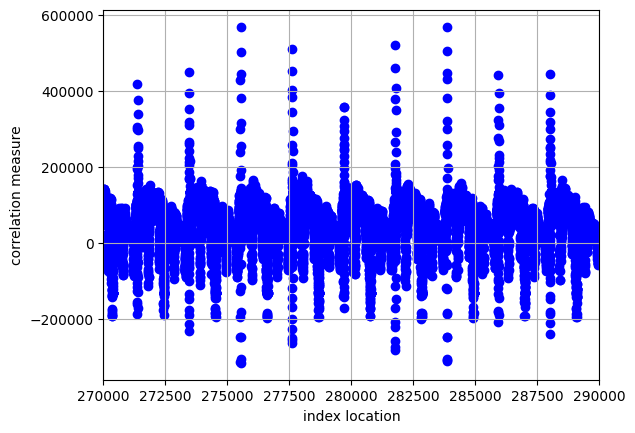

In [10]:
correlation_stats = pd.DataFrame(stats_table)

#grab random slice for better viz
correlation_example = correlation_stats.query('pointer_location >=270000& pointer_location <=290000')

plt.scatter(correlation_example['pointer_location'], correlation_example['correlation'], color='blue', marker='o')

plt.xlabel('index location')
plt.ylabel('correlation measure')
plt.grid()
plt.xlim(270000, 290000)

In [11]:
def is_peak(window):
    center = len(window) // 2
    return window[center] == max(window) and center > 0 and center < len(window) - 1

# Apply a rolling window to identify peaks
window_size = 2001
correlation_stats['is_peak'] = correlation_stats['correlation'].rolling(window=window_size, center=True).apply(lambda x: is_peak(x), raw=True).astype(bool)

# Mark peaks in the DataFrame
correlation_stats['peak_marker'] = np.where(correlation_stats['is_peak'], 'Peak', '')

cp = correlation_stats.query('is_peak')
cp['lag'] = cp['pointer_location'].shift()

In [12]:
cp['window'] = cp['pointer_location'] - cp['lag']

In [13]:
cp = cp.query('window > 2076').query('window <2083').reset_index()

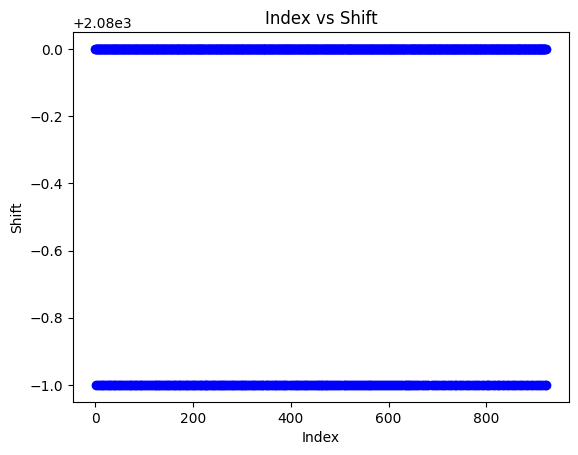

In [14]:
plt.scatter(cp.index, cp['window'], color='blue', marker='o', label='Shift Values')
plt.xlabel('Index')
plt.ylabel('Shift')
plt.title('Index vs Shift')
plt.show()

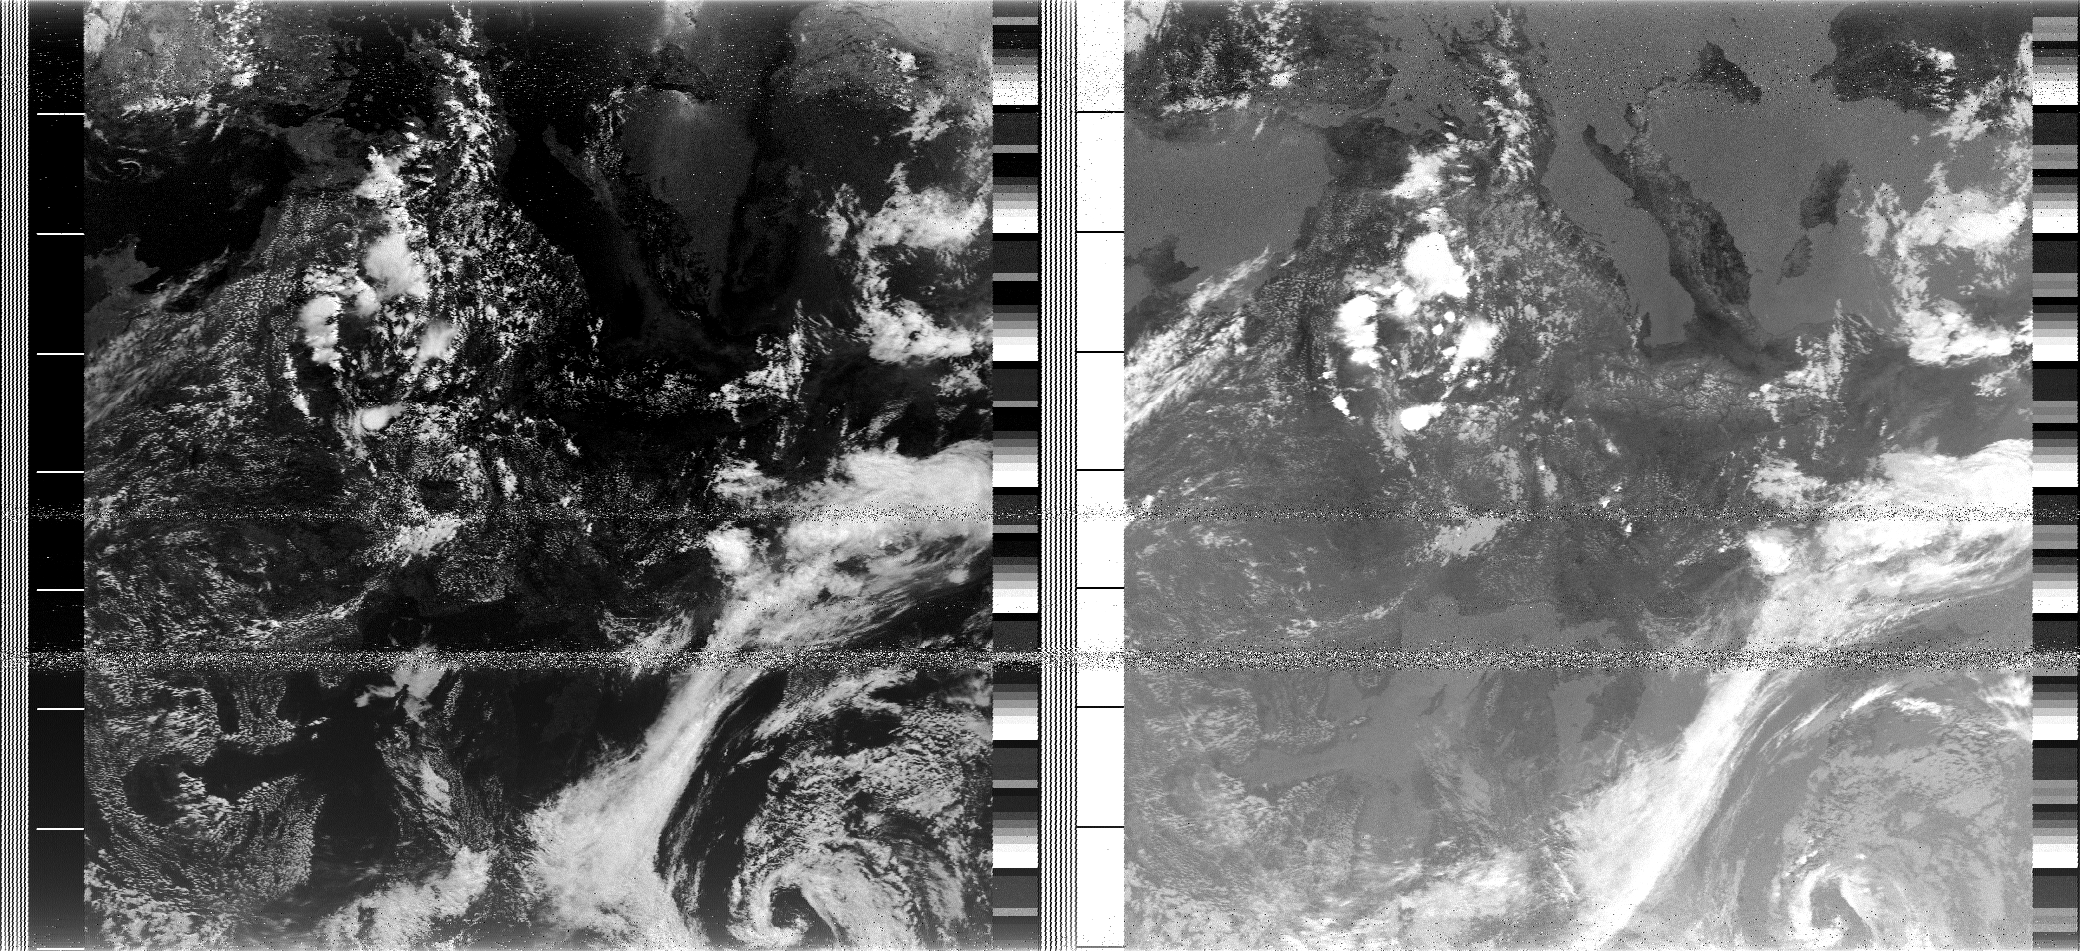

In [15]:
image = np.vstack([row for row in rows if len(row) == 2080]).astype(np.uint8)

from PIL import Image

Image.fromarray(image)

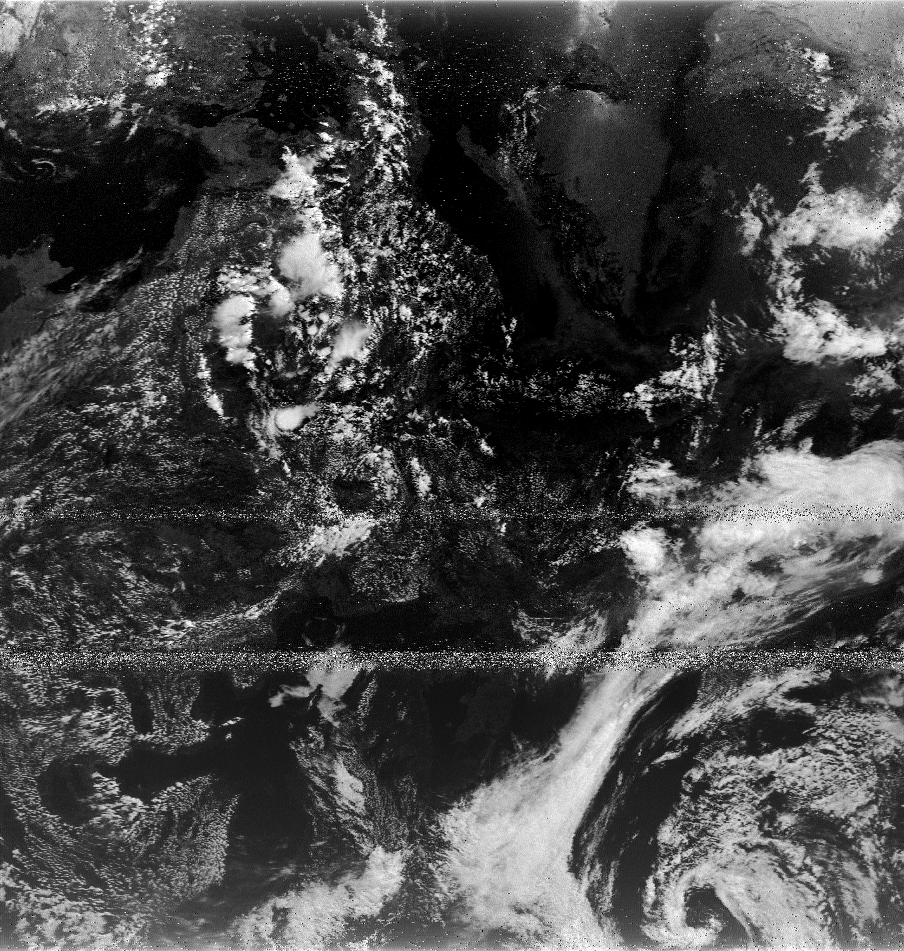

In [16]:
image_a = image[:, 86:990]
Image.fromarray(image_a)

In [17]:
palette_path = 'noaa-apt-daylight.png'
palette_img = Image.open(palette_path)
palette = np.array(palette_img)
indices = np.arange(256)
palette_colors = palette[indices, indices]

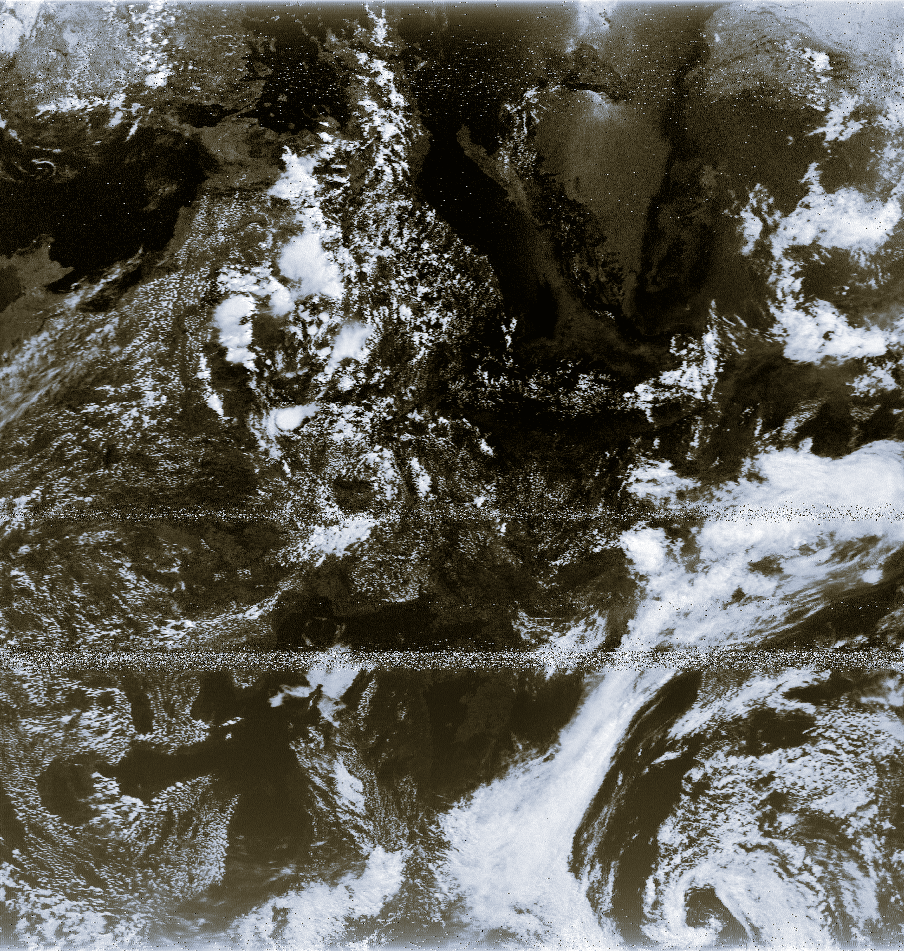

In [18]:
grayscale_array = image_a
height, width = grayscale_array.shape
colored = np.zeros((height, width, 3), dtype=np.uint8)

flat_gray = grayscale_array.flatten()
colored_flat = palette_colors[flat_gray, :3]

colored = colored_flat.reshape(height, width, 3)
Image.fromarray(colored)